In [1]:
import os
import numpy as np
import xarray as xr
from som import SOM, GeoSOM, SSIM
import pandas as pd
import datetime
from datetime import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts
from gesospatialmutils import subseason
from scipy.stats import percentileofscore
import importlib

In [2]:
RUN_TEST = True
idx_dict = {r't2m': 't2m',
            r'500z': 'z',
            r'500t': 't',
            r'850t': 't',
            r'cape': 'cape',
            r'cp': 'cp',
            r'msl': 'msl',
            r'tcciw': 'tciw',
            r'tcclw': 'tclw',
            r'tcwv': 'tcwv',
            r'ice_frac': 'ice_frac',
            r'dT_dp': 'dT_dp',
            r'dtheta': 'dtheta'}
som_dims = '57'
som_epcs = '500'
duff = subseason(datetime(1986, 6, 11),
                 datetime(2022, 7, 9))

plotting t2m


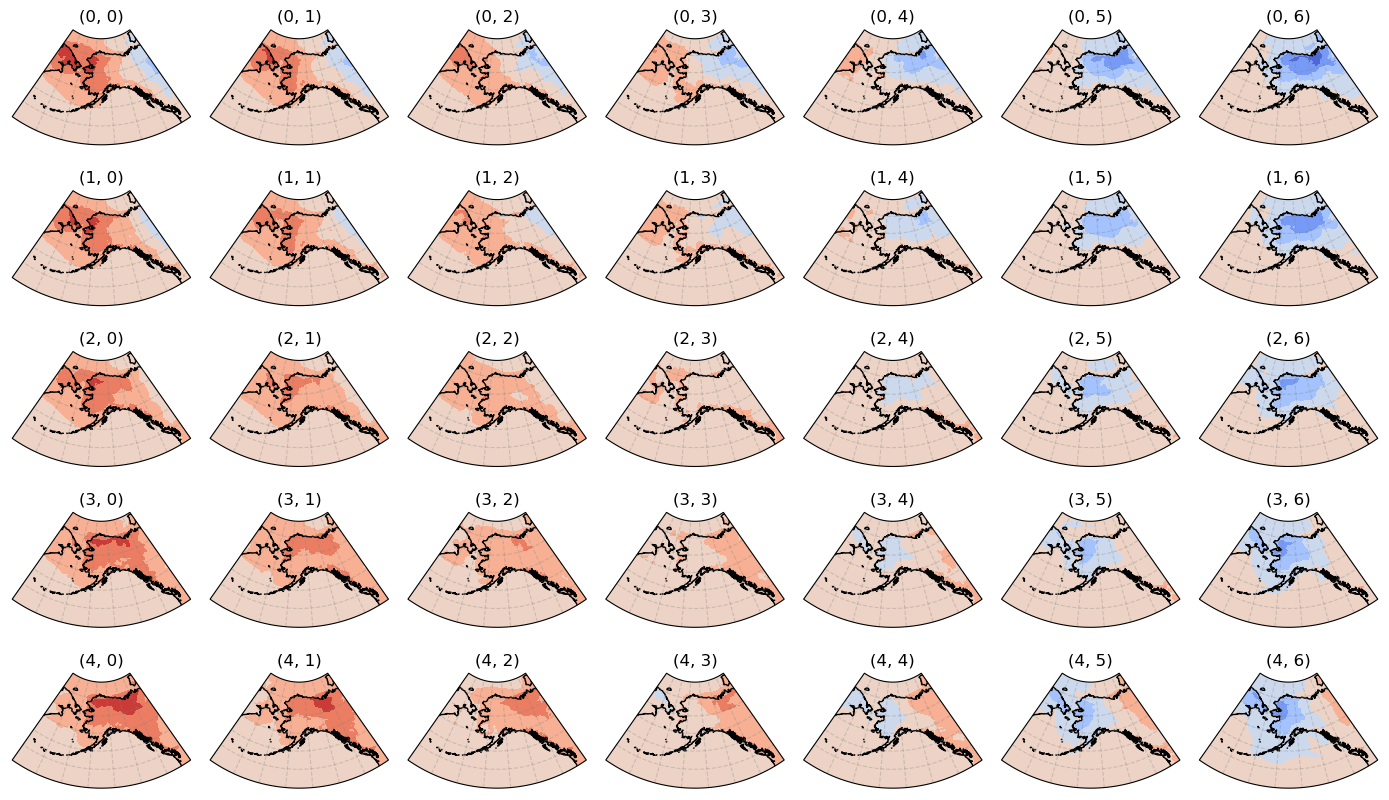

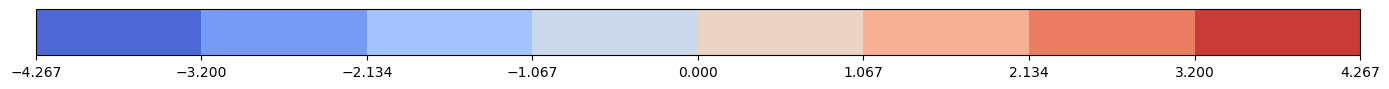

plotting 500z


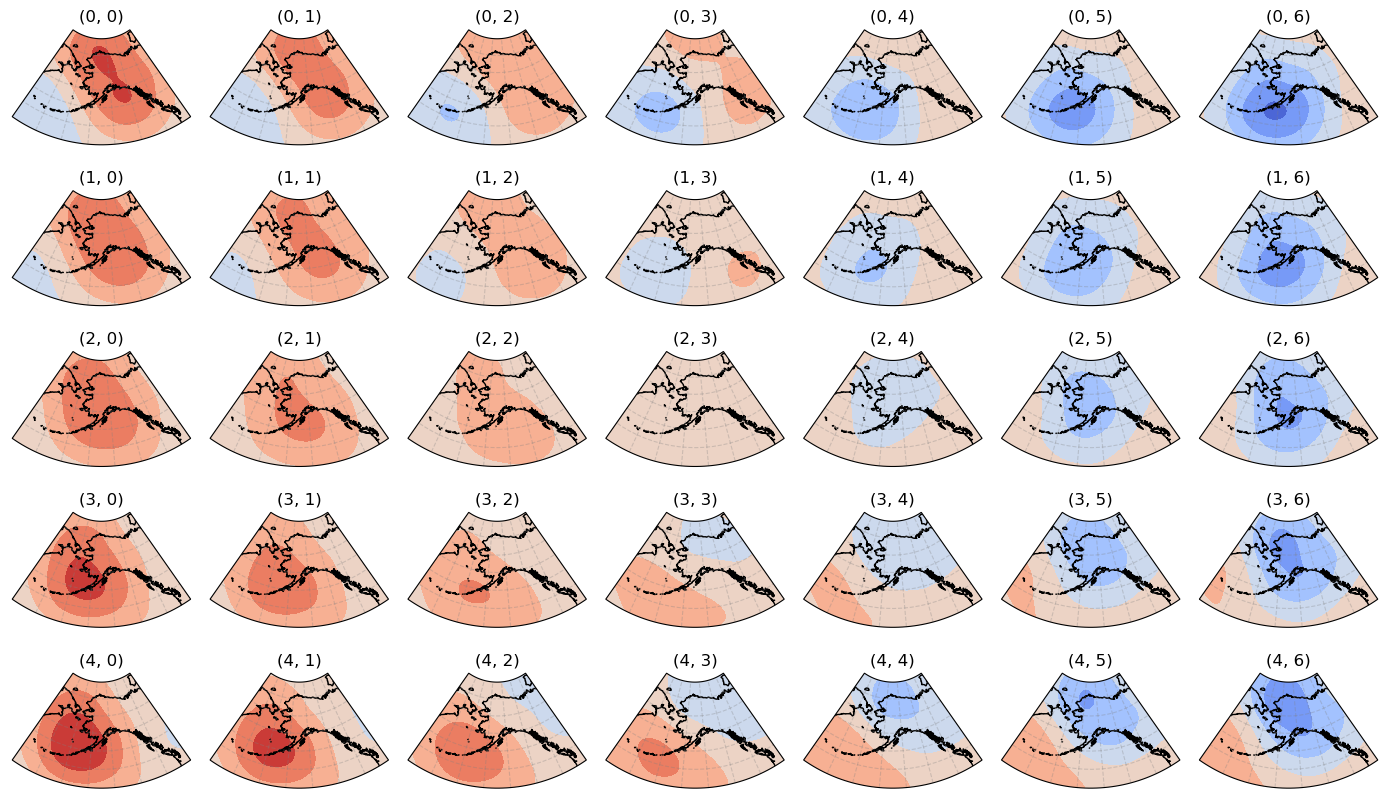

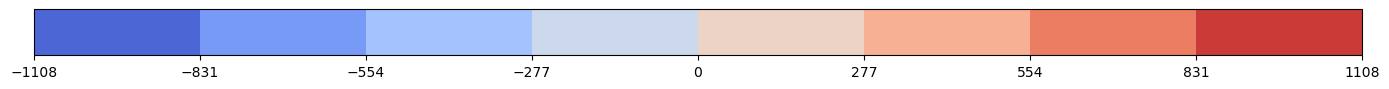

plotting 500t


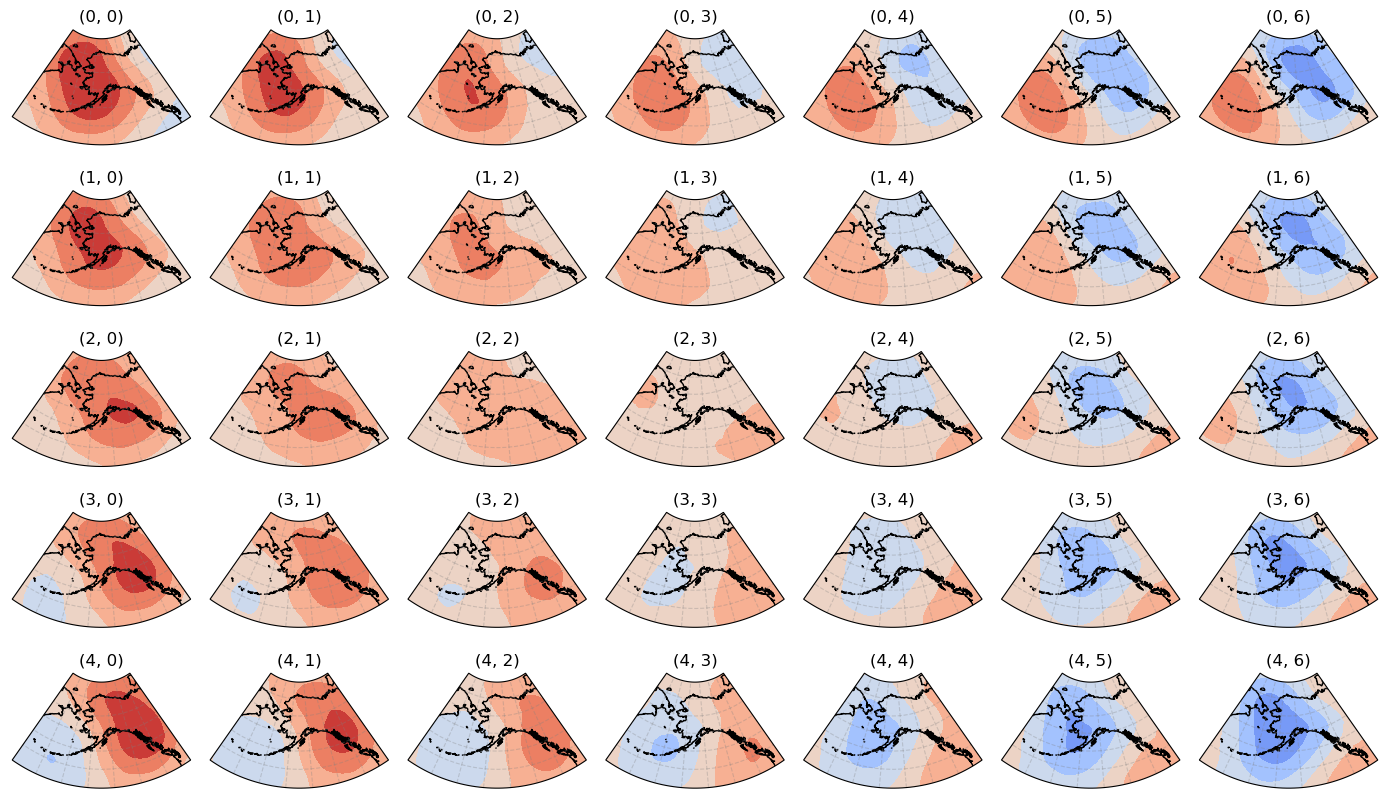

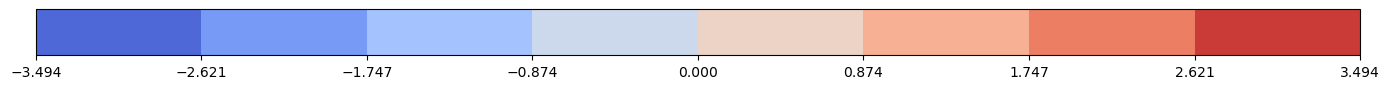

plotting 850t


In [ ]:
for key, v in idx_dict.items():
    fn_out = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\AMJJAS_' + key + '_57_500.csv'
    if not os.path.exists(fn_out):
        fn = r'C:\\Users\\harpe\\PycharmProjects\\synoptic-SOM\\data\\AMJJAS_anom_' + key + '.nc'
        ds = xr.open_dataset(fn)
        ds = ds.sel(time=duff)
        ds = ds.fillna(0)
        dim = ds[v].values.shape[1]*ds[v].values.shape[2]
        count = ds[v].values.shape[0]
        vals = ds[v].values.reshape(count, dim)

        print(f'Training {key}')

        gs_v = GeoSOM(rows=5, cols=7, dim=dim, lons=ds['longitude'], lats=ds['latitude'])
        gs_v.fit(obs_cpu=vals, lr=1, epoch=500, k=1, init_fn=None)
        gs_v.to_csv(fn_out)
        gs_v.plot_nodes(path_out=r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\figs\duff_anom_' + key + '_57_500.png')
        print(gs_v.TE(vals))

    else:
        print(f'plotting {key}')
        fn = r'C:\\Users\\harpe\\PycharmProjects\\synoptic-SOM\\data\\AMJJAS_anom_' + key + '.nc'
        ds = xr.open_dataset(fn)
        s = SOM.from_csv(fn_out)

        gs_v = GeoSOM(s.rows, s.cols, s.dim, lons=ds['longitude'], lats=ds['latitude'])
        gs_v.nodes = s.nodes.copy()
        gs_v.plot_nodes(path_out=r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\figs\AMJJAS_anom' + key + '_57_500.png')


In [4]:
RF_dict = {r't2m': 't2m',
            r'500z': 'z',
            r'500t': 't',
            r'850t': 't',
            r'cape': 'cape',
            r'cp': 'cp',
            r'msl': 'msl',
            r'tcciw': 'tciw',
            r'tcclw': 'tclw',
            r'tcwv': 'tcwv',
            r'ice_frac': 'ice_frac',
            r'dtheta': 'dtheta'}

'''RF_dict = {r't2m': 't2m',
            r'500z': 'z',
            r'500t': 't',
            r'850t': 't',
            r'msl': 'msl',
            r'tcwv': 'tcwv'}'''

label_df = pd.DataFrame()
for key, v in RF_dict.items():
    fn_ds = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\data\AMJJAS_anom_' + key + '.nc'
    fn_som =  r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\AMJJAS_' + key + '_57_500.csv'

    ds = xr.open_dataset(fn_ds)
    s = SOM.from_csv(fn_som)
    gs = GeoSOM(s.rows, s.cols, s.dim, ds['longitude'], ds['latitude'])
    gs.nodes = s.nodes.copy()

    dim = ds[v].values.shape[1] * ds[v].values.shape[2]
    count = ds[v].values.shape[0]
    vals = ds[v].values.reshape(count, dim)

    labels = gs.mk_labels(vals)
    df = pd.DataFrame(data=labels, index=ds.time.values, columns=[key+'_row', key+'_column'])
    label_df = pd.concat([label_df, df], axis=1)

In [5]:
wind = subseason(datetime(1986, 5, 1),
                 datetime(2022, 6, 10))

duff = subseason(datetime(1986, 6, 11),
                 datetime(2022, 7, 9))

drought = subseason(datetime(1986, 7, 10),
                    datetime(2022, 8, 15))

diurnal = subseason(datetime(1986, 8, 16),
                    datetime(2022, 9, 30))

fseason = subseason(datetime(2012, 5, 1),
               datetime(2022, 9, 30))

fn_ltg = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\ltg\PSA_ltg_1986_2022'
df_ltg = pd.read_csv(fn_ltg, parse_dates=True, index_col=0)
df_ltg = df_ltg.fillna(0).reindex(index=fseason, fill_value=0)
df_ltg = df_ltg[df_ltg.index.year != 1989]
df_ltg = df_ltg[df_ltg.index.year != 1987]

east_interior = ['Tanana Valley-East', 'Tanana Valley-West', 'Tanana Zone-North', 'Tanana Zone-South', 'Upper Yukon Valley']
west_interior = ['Koyukuk and Upper Kobuk', 'Middle Yukon', 'Lower Yukon', 'Kuskokwim Valley']
south_central = ['Susitna Valley', 'Copper River Basin', 'Kenai Peninsula', 'Matanuska Valley and Anchorage']
north_slope = ['North Slope']
psa_list = [east_interior, west_interior, south_central, north_slope]
model_dict = {}
psa_dict = {'east_interior': east_interior,
            'east_west_south': east_interior + west_interior + south_central,
            'west_interior': west_interior,
            'south_central': south_central}

#ml_df = label_df.loc[fseason]
#ml_df['dayofyear'] = ds.dayofyear.sel(time=jj).values
#ml_df['strokes'] = event_df['sum'].values
#df_daylength = pd.read_csv(r'C:\Users\harpe\PycharmProjects\synoptic-SOM\ltg\daylengths', parse_dates=True, index_col=0)
#idx = df_daylength.index.intersection(event_df.index)
#df_daylength = df_daylength.loc[idx]
#bins = np.arange(12.5, 22.5, 1)
#labs = (bins[0:-1] + bins[1:]) / 2

In [6]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.dummy import DummyClassifier
from sklearn.metrics import r2_score, confusion_matrix, roc_auc_score, f1_score, make_scorer, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score
import pickle


#psa_dict = dict(map(lambda a: (a, a), east_interior))

f1_scorer = make_scorer(f1_score)
f2_scorer = make_scorer(fbeta_score, beta=2)
scores_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'f2_score', 'AUROC'], index=psa_dict.keys())

for k in psa_dict.keys():
    fn_pickle = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\RF_2012_' + k + '.pkl'
    if not os.path.exists(fn_pickle):
        print(f'fitting {k}')
        ml_df = label_df.loc[fseason]
        ml_df['strokes'] = df_ltg[psa_dict[k]].sum(axis=1)
        #ml_df = ml_df.fillna(0)
        target_name = 'strokes'
        X = ml_df.drop([target_name], axis=1).values.copy()
        y = np.copy(ml_df[target_name].values)


        '''daylength_temp = df_daylength.loc[ml_df[ml_df[target_name] > 0].index]
        daylength_temp['strokes'] = y
        groups = daylength_temp.groupby(pd.cut(daylength_temp.daylength, bins, labels=labs))
        s1 = groups.strokes.quantile(1/3)
        p1 = np.poly1d(np.polyfit(labs, np.log(s1.values), deg=1))

        s2 = groups.strokes.quantile(2/3)
        p2 = np.poly1d(np.polyfit(labs, np.log(s2.values), deg=1))


        ytemp0 = y < np.exp(p1(daylength_temp.daylength.values))
        ytemp1 = (y > np.exp(p1(daylength_temp.daylength.values))) & (y < np.exp(p2(daylength_temp.daylength.values)))
        ytemp2 = y > np.exp(p2(daylength_temp.daylength.values))
        y[ytemp0] = 0
        y[ytemp1] = 1
        y[ytemp2] = 2
        y = y.astype(np.int16)
        print(np.unique(y))'''

        ytemp0 = y < 2
        ytemp1 = y >= 2
        y[ytemp0] = 0
        y[ytemp1] = 1
        y = y.astype(np.int16)
        print(np.unique(y))



        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        rand_state = 42
        X_train, X_test, y_train, y_test = tts(X_scaled, y, test_size=0.2, stratify=y, random_state=rand_state)
        RF_estimator = RandomForestClassifier(n_estimators=200, criterion='entropy',random_state=rand_state, n_jobs=2, min_samples_split=9)

        max_depth = np.linspace(2, 51, 49, dtype=int)
        max_features = np.linspace(0.1, 1.0, 11)
        min_samples_leaf = np.linspace(1, 21, 5, dtype=int)
        param_grid = {'max_depth': max_depth,
                      'max_features': max_features
                      }

        clf = GridSearchCV(RF_estimator, param_grid, scoring=f1_scorer, n_jobs=10, cv=5, verbose=2)
        clf.fit(X_train, y_train)
        print(f'Best fbeta-score of {clf.best_score_} with parameters: \n {clf.best_params_}')

        preds = clf.predict(X_test)
        pred_proba = clf.predict_proba(X_test)
        print(f'TEST results for {k}')
        print(f'Conusion matrix:\n {confusion_matrix(y_test, preds)}')
        scores_df.loc[k] = [precision_score(y_test, preds),
                            recall_score(y_test, preds),
                            f1_score(y_test, preds),
                            fbeta_score(y_test, preds, beta=2),
                            roc_auc_score(y_true=y_test, y_score=pred_proba[:,1])]
        print(scores_df.loc[k])

        model_dict[k] = clf
        pickle.dump(model_dict[k], open(fn_pickle, 'wb'))

In [7]:
scores_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'f2_score', 'AUROC'], index=psa_dict.keys())

for k in psa_dict.keys():
    fn_pickle = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\RF_tercilesb_' + k + '.pkl'
    if not os.path.exists(fn_pickle):
        print(f'fitting {k}')
        ml_df = label_df.loc[jj]
        ml_df['strokes'] = event_df[psa_dict[k]].sum(axis=1)
        ml_df = ml_df.fillna(0)
        target_name = 'strokes'
        X = ml_df[ml_df[target_name] > 0].drop([target_name], axis=1).values.copy()
        y = np.copy(ml_df[ml_df[target_name] > 0][target_name].values)
        tercile1 = np.quantile(y, 1/3) + 0.00001
        tercile2 = np.quantile(y, 2/3) + 0.00001

        ytemp = y < tercile1
        ytemp1 = (y > tercile1) & (y < tercile2)
        ytemp2 = y > tercile2
        y[ytemp] = 0
        y[ytemp1] = 1
        y[ytemp2] = 2
        y = y.astype(np.int16)
        print(np.unique(y))


        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        rand_state = 42
        X_train, X_test, y_train, y_test = tts(X_scaled, y, test_size=0.2, stratify=y, random_state=rand_state)
        RF_estimator = RandomForestClassifier(n_estimators=200, random_state=rand_state, n_jobs=2, min_samples_split=9)

        max_depth = np.linspace(11, 100, 90, dtype=int)
        max_features = np.linspace(0.3, 1.0, 36)
        min_samples_leaf = np.linspace(1, 21, 5, dtype=int)
        param_grid = {'max_depth': max_depth,
                      'max_features': max_features,
                      'min_samples_leaf': min_samples_leaf
                      }

        clf = GridSearchCV(RF_estimator, param_grid, scoring=f1_scorer, n_jobs=10, cv=3, verbose=2)
        clf.fit(X_train, y_train)
        print(f'Best fbeta-score of {clf.best_score_} with parameters: \n {clf.best_params_}')

        preds = clf.predict(X_test)
        pred_proba = clf.predict_proba(X_test)
        print(f'TEST results for {k}')
        print(f'Conusion matrix:\n {confusion_matrix(y_test, preds)}')
        scores_df.loc[k] = [precision_score(y_test, preds, average='weighted'),
                            recall_score(y_test, preds, average='weighted'),
                            f1_score(y_test, preds, average='weighted'),
                            fbeta_score(y_test, preds, beta=2, average='weighted'),
                            roc_auc_score(y_true=y_test, y_score=pred_proba, multi_class = 'ovr', average='weighted')]
        print(scores_df.loc[k])

        model_dict[k] = clf
        pickle.dump(model_dict[k], open(fn_pickle, 'wb'))

In [8]:

scores_df = pd.DataFrame(columns=['precision', 'recall', 'f1_score', 'f2_score', 'AUROC'], index=psa_dict.keys())
for k in psa_dict.keys():
    fn_pickle = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\RF_2012_' + k + '.pkl'
    model = pickle.load(open(fn_pickle, 'rb'))
    ml_df = label_df.loc[fseason]
    ml_df['strokes'] = df_ltg[psa_dict[k]].sum(axis=1).copy()
    target_name = 'strokes'
    X = ml_df.drop([target_name], axis=1).values.copy()
    y = np.copy(ml_df[target_name].values)
    ytemp0 = y < 2
    ytemp1 = y >= 2
    y[ytemp0] = 0
    y[ytemp1] = 1
    y = y.astype(np.int16)


    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    rand_state = 42
    X_train, X_test, y_train, y_test = tts(X_scaled, y, test_size=0.2, stratify=y, random_state=rand_state)

    preds = model.predict(X_test)
    pred_proba = model.predict_proba(X_test)

    scores_df.loc[k] = [precision_score(y_test, preds),
                        recall_score(y_test, preds),
                        f1_score(y_test, preds),
                        fbeta_score(y_test, preds, beta=2),
                        roc_auc_score(y_true=y_test, y_score=pred_proba[:,1])]

In [9]:
print(scores_df)

                precision    recall  f1_score  f2_score     AUROC
east_interior       0.768  0.901408  0.829374  0.871143  0.821937
east_west_south  0.819444  0.940239  0.875696  0.913313   0.83026
west_interior    0.709877  0.692771   0.70122  0.696126  0.798387
south_central    0.727778  0.744318  0.735955   0.74095  0.783738


In [10]:
fseason2012 = subseason(datetime(2012, 5, 1),
               datetime(2022, 9, 30))
fseason1986 = subseason(datetime(2008, 5, 1),
               datetime(2022, 9, 30))
df_ltg = pd.read_csv(fn_ltg, parse_dates=True, index_col=0)
df_ltg = df_ltg.fillna(0).reindex(index=fseason1986, fill_value=0)
df_ltg = df_ltg[df_ltg.index.year != 1989]
df_ltg = df_ltg[df_ltg.index.year != 1987]


fn_pickle = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\RF_2012_' + 'east_interior' + '.pkl'
model = pickle.load(open(fn_pickle, 'rb'))
ml_df = label_df.loc[df_ltg.index]
ml_df['strokes'] = df_ltg[psa_dict['east_interior']].sum(axis=1).copy()
#ml_df = ml_df.loc[ml_df.strokes >= 2]
target_name = 'strokes'
X = ml_df.drop([target_name], axis=1).values.copy()
y = np.copy(ml_df[target_name].values)
ytemp0 = y < 2
ytemp1 = y >= 2
y[ytemp0] = 0
y[ytemp1] = 1
y = y.astype(np.int16)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

preds = model.predict(X_scaled)

results_df = pd.DataFrame(data={'Actual': y, 'Predicted': preds}, index=ml_df.index)

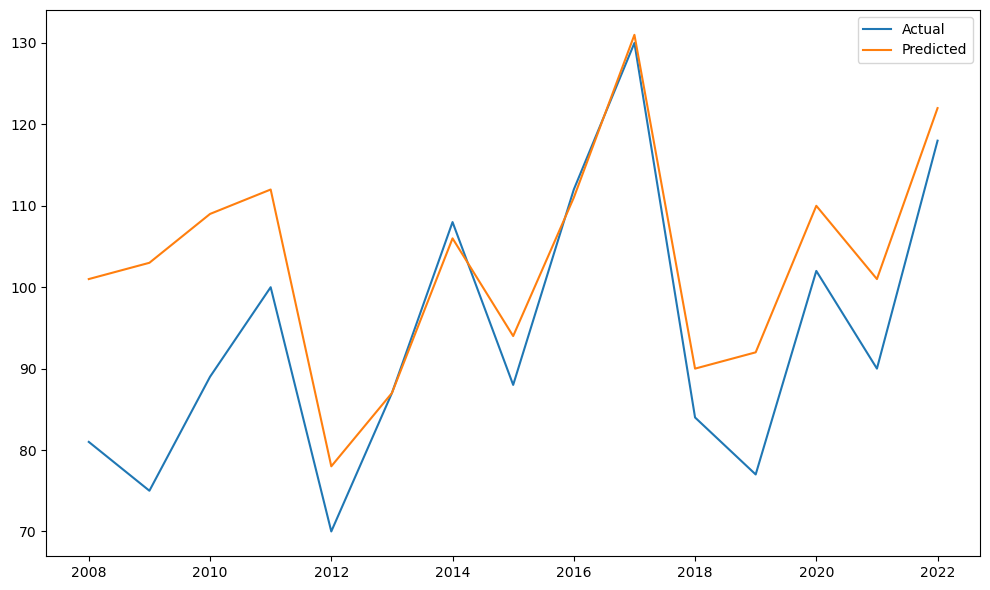

In [11]:
annual = results_df.groupby(results_df.index.year).sum()
fig = plt.figure(figsize=(10,6))
annual['Actual'].plot()
annual['Predicted'].plot()
plt.legend()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance
AUROC_scorer = make_scorer(roc_auc_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
scorer_dict = {'F1-Score': f1_scorer,
               'F2-Score': f2_scorer,
               'Precision Score': precision_scorer,
               'Recall Score': recall_scorer}
feature_names = ml_df.drop([target_name], axis=1).columns
result_test = permutation_importance(model_dict['east_interior'], X_test, y_test, n_repeats=200, n_jobs=10, random_state=rand_state, scoring=scorer_dict)
fig, axs = plt.subplots(len(scorer_dict), 1, figsize=(8.5, 22))
ax_idx = 0
plt.rcParams.update({'figure.autolayout': True, 'text.usetex': False, 'axes.titlesize': 12})
for scorer in scorer_dict.keys():
    ax=axs.flatten()[ax_idx]
    forest_importances = pd.Series(result_test[scorer].importances_mean, index=feature_names)
    forest_importances.plot.bar(yerr=result_test[scorer].importances_std, ax=ax)
    ax.set_title(f'Permutation feature importances for {scorer} on training data')
    ax_idx+=1

plt.show()

In [ ]:
target_name = 'strokes'
X = ml_df.drop([target_name], axis=1).values.copy()
y = np.copy(ml_df[target_name].values)
ytemp0 = y < 1
ytemp1 = y >= 1
y[ytemp0] = 0
y[ytemp1] = 1
y = y.astype(np.int16)


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rand_state = 42
X_train, X_test, y_train, y_test = tts(X_scaled, y, test_size=0.2, stratify=y, random_state=rand_state)

In [ ]:


f1_scorer = make_scorer(f1_score)
RF_estimator = RandomForestClassifier(n_estimators=200, random_state=rand_state, n_jobs=2, min_samples_split=9)

max_depth = np.linspace(11, 100, 90, dtype=int)
max_features = np.linspace(0.3, 1.0, 36)
min_samples_leaf = np.linspace(1, 21, 5, dtype=int)
param_grid = {'max_depth': max_depth,
              'max_features': max_features,
              'min_samples_leaf': min_samples_leaf
              }

clf = GridSearchCV(RF_estimator, param_grid, scoring=f1_scorer, n_jobs=10, cv=5, verbose=2)
clf.fit(X_train, y_train)
print(f'Best f1-score of {clf.best_score_} with parameters: \n {clf.best_params_}')

In [ ]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
RF_estimator = RandomForestClassifier(n_estimators=100, random_state=rand_state, n_jobs=2)
parameters = {'max_depth': Integer(50, 80),
              'min_samples_split': Integer(18, 50),
              'max_leaf_nodes': Integer(90, 500),
              'max_features': Real(1e-4, 1e0, prior='log-uniform'),
              'min_samples_leaf': Real(1e-3, 1e-1, prior='log-uniform')
              }

opt = BayesSearchCV(RF_estimator, parameters, scoring=f1_scorer,
                    n_iter=200, n_jobs=10, n_points=2,
                    random_state=rand_state, cv=5)

search = opt.fit(X_train, y_train)

print(opt.best_score_)
print(opt.best_params_)

In [ ]:
print(opt.cv_results_['std_test_score'][opt.best_index_])

In [ ]:
if RUN_TEST:
    print(opt.score(X_test,y_test))

In [ ]:

if RUN_TEST:
    preds = opt.predict(X_test)
    pred_proba = opt.predict_proba(X_test)
    print(f'Conusion matrix:\n {confusion_matrix(y_test, preds)}')
    print(f'AUROC: {roc_auc_score(y_true=y_test, y_score=pred_proba[:,1])}')
    print(f'Precision: {precision_score(y_test, preds)}')
    print(f'Recall: {recall_score(y_test, preds)}')
    print(f'F1-Score: {f1_score(y_test, preds)}')

In [ ]:
best_params_gridCV = {'n_estimators': 200,
                      'min_samples_split': 9,
                      'max_depth': 19,
                      'max_features': 0.42,
                      'min_samples_leaf': 1}
best_forest = RandomForestClassifier(**best_params_gridCV, random_state=rand_state, n_jobs=10)
best_forest.fit(X_train, y_train)
feature_names = ml_df.drop([target_name], axis=1).columns
importances = best_forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_forest.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [ ]:
if RUN_TEST:
    preds = best_forest.predict(X_test)
    pred_proba = best_forest.predict_proba(X_test)
    print(f'Conusion matrix:\n {confusion_matrix(y_test, preds)}')
    print(f'AUROC: {roc_auc_score(y_true=y_test, y_score=pred_proba[:,1])}')
    print(f'Precision: {precision_score(y_test, preds)}')
    print(f'Recall: {recall_score(y_test, preds)}')
    print(f'F1-Score: {f1_score(y_test, preds)}')

In [ ]:
from sklearn.inspection import permutation_importance
AUROC_scorer = make_scorer(roc_auc_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
scorer_dict = {'F1-Score': f1_scorer,
               'Precision Score': precision_scorer,
               'Recall Score': recall_scorer}

In [ ]:
result_train = permutation_importance(best_forest, X_train, y_train,
                                n_repeats=100, n_jobs=10, random_state=rand_state,
                                scoring=scorer_dict)

In [ ]:
fig, axs = plt.subplots(len(scorer_dict), 1, figsize=(8.5, 22))
ax_idx = 0
plt.rcParams.update({'figure.autolayout': True, 'text.usetex': False, 'axes.titlesize': 12})
for scorer in scorer_dict.keys():
    ax=axs.flatten()[ax_idx]
    forest_importances = pd.Series(result_train[scorer].importances_mean, index=feature_names)
    forest_importances.plot.bar(yerr=result_train[scorer].importances_std, ax=ax)
    ax.set_title(f'Permutation feature importances for {scorer} on training data')
    ax_idx+=1

plt.show()

In [ ]:
if RUN_TEST:
    result_test = permutation_importance(best_forest, X_test, y_test, n_repeats=200, n_jobs=10, random_state=rand_state, scoring=scorer_dict)

In [ ]:
if RUN_TEST:
    fig, axs = plt.subplots(len(scorer_dict), 1, figsize=(8.5, 22))
    ax_idx = 0
    for scorer in scorer_dict.keys():
        ax=axs.flatten()[ax_idx]
        forest_importances = pd.Series(result_test[scorer].importances_mean, index=feature_names)
        forest_importances.plot.bar(yerr=result_test[scorer].importances_std, ax=ax)
        ax.set_title(f'Permutation feature importances for {scorer} on test data')
        ax_idx+=1

    plt.show()

In [ ]:
for scorer in scorer_dict.keys():
    s_train = pd.Series(result_train[scorer].importances_mean, index=feature_names)
    s_test = pd.Series(result_test[scorer].importances_mean, index=feature_names)
    dfn = pd.DataFrame({f'train {scorer}': s_train,
                        f'test {scorer}': s_test})
    dfn.plot.bar()
    plt.show()

In [ ]:
s_recall = pd.Series(result_train['Recall Score'].importances_mean, index=feature_names)
s_precision = pd.Series(result_train['Precision Score'].importances_mean, index=feature_names)
dfn = pd.DataFrame({'Recall': s_recall,
                    'Precision': s_precision})

dfn.plot.bar()
plt.show()

In [ ]:
s_recall = pd.Series(result_test['Recall Score'].importances_mean, index=feature_names)
s_precision = pd.Series(result_test['Precision Score'].importances_mean, index=feature_names)
dfn = pd.DataFrame({'Recall': s_recall,
                    'Precision': s_precision})

dfn.plot.bar()
plt.show()

In [ ]:
KNN_dict = {r't2m': 't2m',
            r'500z': 'z',
            r'500t': 't',
            r'850t': 't',
            r'cape': 'cape',
            r'cp': 'cp',
            r'msl': 'msl',
            r'tcciw': 'tciw',
            r'tcclw': 'tclw',
            r'tcwv': 'tcwv',
            r'ice_frac': 'ice_frac',
            r'dtheta': 'dtheta'}

df_SSIM = pd.DataFrame()
for key, v in KNN_dict.items():
    fn_SSIM = r'C:\Users\harpe\PycharmProjects\synoptic-SOM\results\SSIM_KNN_' + key + '.csv'
    df_SSIMn = pd.read_csv(fn_SSIM, parse_dates=True, index_col=0)
    df_SSIM = df_SSIM.add(df_SSIMn, fill_value=0)

df_SSIM = df_SSIM / len(KNN_dict)
df_DISSIM = 1 - df_SSIM

In [ ]:
mask_offset = 0
DISSIM = df_DISSIM.values.copy()
for offset in range(-mask_offset, mask_offset+1):
    x = DISSIM.diagonal(offset=offset)
    x.setflags(write=1)
    x[:] = 2
X_train, X_test, y_train, y_test = tts(np.arange(len(DISSIM)), y, test_size=0.2, stratify=y, random_state=rand_state)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kfsplits = 5
kf = KFold(n_splits=kfsplits, shuffle=True, random_state=rand_state)
f1avg=0
for train_idx, val_idx in kf.split(X_train):
    clf = KNeighborsClassifier(n_neighbors=21, metric='precomputed', weights='distance')

    clf.fit(
        DISSIM[X_train[train_idx]][:, X_train[train_idx]],
        y_train[train_idx]
    )

    y_true = y_train[val_idx]
    pred = clf.predict(DISSIM[X_train[val_idx]][:, X_train[train_idx]])
    f1 = f1_score(y_true, pred)
    f1avg = f1avg + f1 / kfsplits
    print(f1)
print(f'average f1 score: {f1avg}')

In [ ]:
if RUN_TEST:
    model = KNeighborsClassifier(n_neighbors=21, metric='precomputed', weights='distance')
    model.fit(
        DISSIM[X_train][:, X_train],
        y_train
    )
    preds = model.predict(DISSIM[X_test][:, X_train])
    print(f'Confusion Matrix: \n {confusion_matrix(y_test, preds)}')
    print(f'F1-Score: {f1_score(y_test, preds, average=None)}')
    print(f'Precision Score: {precision_score(y_test, preds, average=None)}')
    print(f'Recall Score: {recall_score(y_test, preds, average=None)}')